In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import bokeh
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, BoxSelectTool

from matplotlib.pyplot import figure

# Autoencoder
import keras
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

In [6]:
! pip install kaggle
! mkdir ~/.kaggle
uploaded = files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle.json


In [7]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tcrammond/food-access-and-food-deserts

100% 20.0M/20.0M [00:00<00:00, 109MB/s] 
100% 20.0M/20.0M [00:00<00:00, 99.1MB/s]


In [8]:
! unzip food-access-and-food-deserts.zip

Archive:  food-access-and-food-deserts.zip
  inflating: food_access_research_atlas.csv  
  inflating: food_access_variable_lookup.csv  


In [9]:
df = pd.read_csv('food_access_research_atlas.csv')
df.head()

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga,1,1912,693,0,0,0.000000,0,...,221,1622,217,14,0,14,45,44,26,112
1,1001020200,Alabama,Autauga,1,2170,743,0,181,0.083410,0,...,214,888,1217,5,0,5,55,75,87,202
2,1001020300,Alabama,Autauga,1,3373,1256,0,0,0.000000,0,...,439,2576,647,17,5,11,117,87,108,120
3,1001020400,Alabama,Autauga,1,4386,1722,0,0,0.000000,0,...,904,4086,193,18,4,11,74,85,19,82
4,1001020500,Alabama,Autauga,1,10766,4082,0,181,0.016812,0,...,1126,8666,1437,296,9,48,310,355,198,488


In [10]:
variables = pd.read_csv('food_access_variable_lookup.csv')
variables

,Field,LongName,Description
0,CensusTract,Census tract,Census tract number
1,State,State,State name
2,County,County,County name
3,Urban,Urban tract,Flag for urban tract
4,POP2010,"Population, tract total",Population count from 2010 census
...,...,...,...
142,TractAIAN,Tract American Indian and Alaska Native popula...,Total count of American Indian and Alaska Nati...
143,TractOMultir,"Tract Other/Multiple race population, number",Total count of Other/Multiple race population ...
144,TractHispanic,"Tract Hispanic or Latino population, number",Total count of Hispanic or Latino population i...
145,TractHUNV,"Tract housing units without a vehicle, number",Total count of housing units without a vehicle...


In [11]:

features = df.drop(labels=['CensusTract', 'State', 'County'], axis=1)
features.head()

,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1,1912,693,0,0,0.000000,0,0,0,0,...,221,1622,217,14,0,14,45,44,26,112
1,1,2170,743,0,181,0.083410,0,0,0,0,...,214,888,1217,5,0,5,55,75,87,202
2,1,3373,1256,0,0,0.000000,0,0,0,0,...,439,2576,647,17,5,11,117,87,108,120
3,1,4386,1722,0,0,0.000000,0,0,0,0,...,904,4086,193,18,4,11,74,85,19,82
4,1,10766,4082,0,181,0.016812,0,0,0,0,...,1126,8666,1437,296,9,48,310,355,198,488


In [12]:
labels = df[['CensusTract', 'State', 'County']]
labels.head()

,CensusTract,State,County
0,1001020100,Alabama,Autauga
1,1001020200,Alabama,Autauga
2,1001020300,Alabama,Autauga
3,1001020400,Alabama,Autauga
4,1001020500,Alabama,Autauga


In [13]:
countystate = df['County'] + ", " + df['State']
countystate

0         Autauga, Alabama
1         Autauga, Alabama
2         Autauga, Alabama
3         Autauga, Alabama
4         Autauga, Alabama
               ...        
72859    Washakie, Wyoming
72860    Washakie, Wyoming
72861    Washakie, Wyoming
72862      Weston, Wyoming
72863      Weston, Wyoming
Length: 72864, dtype: object

In [14]:
# Center all data so mean is 0
feature_means = np.mean(features, axis=0)
centered_features = features - feature_means
print(feature_means)
centered_features.head()

Urban                   0.757191
POP2010              4237.285052
OHU2010              1601.837560
GroupQuartersFlag       0.007082
NUMGQTRS              109.619606
                        ...     
TractAIAN              40.242754
TractOMultir          385.875618
TractHispanic         692.764520
TractHUNV             145.356239
TractSNAP             207.022206
Length: 144, dtype: float64


,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,0.242809,-2325.285052,-908.83756,-0.007082,-109.619606,-0.026961,-0.12688,-0.282115,-0.111235,-0.149168,...,-331.645806,-1446.089386,-317.273702,-187.392347,-7.411246,-26.242754,-340.875618,-648.76452,-119.356239,-95.022206
1,0.242809,-2067.285052,-858.83756,-0.007082,71.380394,0.056449,-0.12688,-0.282115,-0.111235,-0.149168,...,-338.645806,-2180.089386,682.726298,-196.392347,-7.411246,-35.242754,-330.875618,-617.76452,-58.356239,-5.022206
2,0.242809,-864.285052,-345.83756,-0.007082,-109.619606,-0.026961,-0.12688,-0.282115,-0.111235,-0.149168,...,-113.645806,-492.089386,112.726298,-184.392347,-2.411246,-29.242754,-268.875618,-605.76452,-37.356239,-87.022206
3,0.242809,148.714948,120.16244,-0.007082,-109.619606,-0.026961,-0.12688,-0.282115,-0.111235,-0.149168,...,351.354194,1017.910614,-341.273702,-183.392347,-3.411246,-29.242754,-311.875618,-607.76452,-126.356239,-125.022206
4,0.242809,6528.714948,2480.16244,-0.007082,71.380394,-0.010149,-0.12688,-0.282115,-0.111235,-0.149168,...,573.354194,5597.910614,902.726298,94.607653,1.588754,7.757246,-75.875618,-337.76452,52.643761,280.977794


In [15]:
u, s , vt = np.linalg.svd(centered_features, full_matrices=False)
u.shape, s, vt.shape

((72864, 144),
 array([9.20758951e+06, 1.27891444e+06, 6.47316141e+05, 5.64555395e+05,
        3.76923214e+05, 3.34550777e+05, 2.98082875e+05, 2.06481145e+05,
        1.53013086e+05, 1.48892805e+05, 1.41216360e+05, 1.25441784e+05,
        1.17960986e+05, 1.09846091e+05, 9.19394248e+04, 8.36906009e+04,
        7.81617084e+04, 7.28755074e+04, 6.29026326e+04, 6.05385678e+04,
        5.43543717e+04, 4.88655427e+04, 4.87613302e+04, 4.79225710e+04,
        4.13921261e+04, 3.83780070e+04, 3.20476083e+04, 2.96918504e+04,
        2.90166723e+04, 2.73274217e+04, 2.42805959e+04, 2.14398726e+04,
        2.02999542e+04, 1.93760357e+04, 1.62745172e+04, 1.56670880e+04,
        1.50903147e+04, 1.37659826e+04, 1.22139220e+04, 1.16330274e+04,
        1.14191824e+04, 1.05144124e+04, 1.04040986e+04, 9.19047091e+03,
        8.17752897e+03, 6.97461726e+03, 6.47663782e+03, 6.35029917e+03,
        5.68217273e+03, 4.74470428e+03, 4.56630538e+03, 4.49099906e+03,
        4.17664901e+03, 3.11284396e+03, 3.0228398

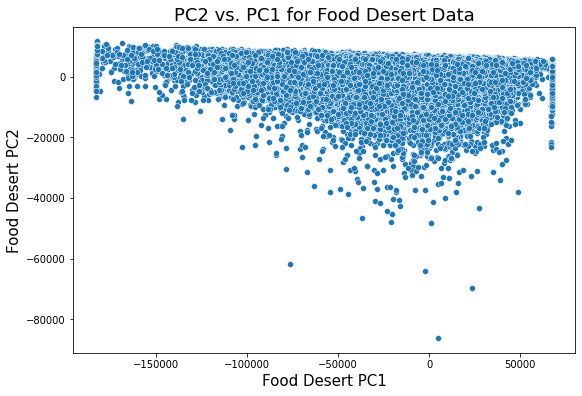

In [16]:
pca_2d = np.dot(centered_features, vt[0:2].T)
# sns.clustermap(pca_2d)
plt.figure(figsize=(9, 6))
plt.title("PC2 vs. PC1 for Food Desert Data", fontsize=18)
plt.xlabel("Food Desert PC1", fontsize=15)
plt.ylabel("Food Desert PC2", fontsize=15)
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1]);

Text(0, 0.5, 'Sum of within cluster variance')

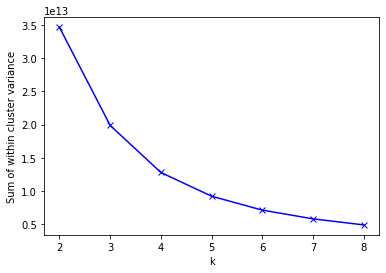

In [17]:
squarederror = []
for k in np.arange(2, 9):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_2d)
    squarederror.append(kmeans.inertia_)
plt.plot(np.arange(2, 9), squarederror, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of within cluster variance')

In [18]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(pca_2d)
clusters = kmeans.predict(pca_2d)

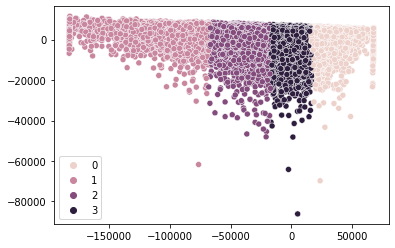

In [19]:
x = []
y = []
for i in pca_2d:
  x.append(i[0])
  y.append(i[1])
sns.scatterplot(x=x, y=y, hue=clusters)

In [22]:
fooddeserts = df[df['LILATracts_1And10'] == 1]
print(len(fooddeserts))
fooddeserts.head()

9245


,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
6,1001020700,Alabama,Autauga,1,2891,1188,0,36,0.012452,1,...,360,2333,435,13,3,11,96,98,134,218
11,1001021100,Alabama,Autauga,0,3320,1306,0,33,0.009940,1,...,493,1441,1810,2,0,14,53,39,196,262
17,1003010600,Alabama,Baldwin,1,3325,1186,0,14,0.004210,1,...,305,1323,1851,3,0,30,118,92,156,311
37,1003011407,Alabama,Baldwin,1,4799,2161,0,4,0.000834,1,...,1040,4525,56,36,1,26,155,57,64,143
40,1003011502,Alabama,Baldwin,1,10534,4330,0,0,0.000000,1,...,1882,7818,1693,113,8,74,828,1314,245,613


In [23]:
fd_features = fooddeserts.drop(labels=['CensusTract', 'State', 'County'], axis=1)
fd_location = fooddeserts['County'] + ", " + fooddeserts['State']

In [24]:
fdfeature_means = np.mean(fd_features, axis=0)
fdcentered_features = fd_features - fdfeature_means
print(fdfeature_means)
fdcentered_features.head()

Urban                   0.855057
POP2010              4263.554029
OHU2010              1579.655273
GroupQuartersFlag       0.012115
NUMGQTRS              185.539319
                        ...     
TractAIAN              84.902866
TractOMultir          445.619794
TractHispanic         855.948837
TractHUNV             152.755435
TractSNAP             336.256138
Length: 144, dtype: float64


,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
6,0.144943,-1372.554029,-391.655273,-0.012115,-149.539319,-0.030830,0.0,0.0,0.12331,0.461979,...,-171.387994,-400.204759,-464.95219,-78.303191,-5.571228,-73.902866,-349.619794,-757.948837,-18.755435,-118.256138
11,-0.855057,-943.554029,-273.655273,-0.012115,-152.539319,-0.033343,0.0,0.0,-0.87669,0.461979,...,-38.387994,-1292.204759,910.04781,-89.303191,-8.571228,-70.902866,-392.619794,-816.948837,43.244565,-74.256138
17,0.144943,-938.554029,-393.655273,-0.012115,-171.539319,-0.039072,0.0,0.0,0.12331,0.461979,...,-226.387994,-1410.204759,951.04781,-88.303191,-8.571228,-54.902866,-327.619794,-763.948837,3.244565,-25.256138
37,0.144943,535.445971,581.344727,-0.012115,-181.539319,-0.042449,0.0,0.0,0.12331,-0.538021,...,508.612006,1791.795241,-843.95219,-55.303191,-7.571228,-58.902866,-290.619794,-798.948837,-88.755435,-193.256138
40,0.144943,6270.445971,2750.344727,-0.012115,-185.539319,-0.043282,0.0,0.0,0.12331,0.461979,...,1350.612006,5084.795241,793.04781,21.696809,-0.571228,-10.902866,382.380206,458.051163,92.244565,276.743862


In [25]:
u2, s2 , vt2 = np.linalg.svd(fdcentered_features, full_matrices=False)
u2.shape, s2, vt2.shape

((9245, 144),
 array([1.32658558e+06, 4.48534260e+05, 2.20367326e+05, 2.04764461e+05,
        1.69501586e+05, 1.34264994e+05, 9.49156661e+04, 7.52920722e+04,
        6.89031170e+04, 6.17818083e+04, 5.66142931e+04, 5.01831568e+04,
        4.05301535e+04, 4.02239872e+04, 3.54930840e+04, 3.18724011e+04,
        2.65053682e+04, 2.45374153e+04, 2.20199211e+04, 2.00525297e+04,
        1.82436270e+04, 1.55994346e+04, 1.51383530e+04, 1.30179569e+04,
        1.25641899e+04, 1.16978747e+04, 1.13807896e+04, 1.08756345e+04,
        9.34867336e+03, 8.92253068e+03, 8.70369974e+03, 8.55754574e+03,
        7.57540749e+03, 7.51445267e+03, 6.84768827e+03, 5.62923320e+03,
        5.43515669e+03, 5.29952297e+03, 5.01036450e+03, 4.66341750e+03,
        4.17474343e+03, 4.02120955e+03, 3.54237144e+03, 3.28450346e+03,
        3.18751516e+03, 2.94888762e+03, 2.75410717e+03, 2.71251950e+03,
        2.33356756e+03, 2.16562788e+03, 2.13281659e+03, 1.93091507e+03,
        1.75208828e+03, 1.64436586e+03, 1.63301237

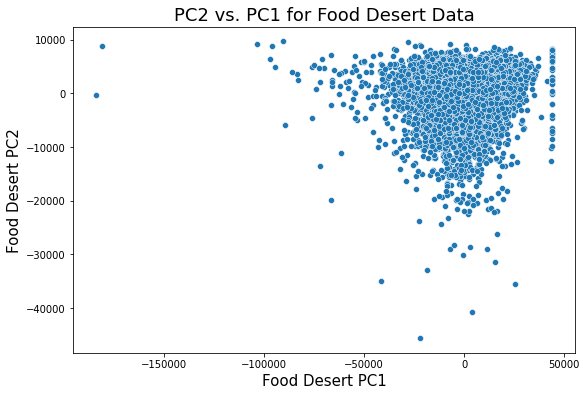

In [26]:
fdpca_2d = np.dot(fdcentered_features, vt[0:2].T)
# sns.clustermap(pca_2d)
plt.figure(figsize=(9, 6))
plt.title("PC2 vs. PC1 for Food Desert Data", fontsize=18)
plt.xlabel("Food Desert PC1", fontsize=15)
plt.ylabel("Food Desert PC2", fontsize=15)
sns.scatterplot(x=fdpca_2d[:, 0], y=fdpca_2d[:, 1]);

In [27]:
two_dim_variance = np.sum((s2[0:2]**2/np.sum(s2**2)))
two_dim_variance

0.9175556718498278

Text(0, 0.5, 'Variance (Component Scores)')

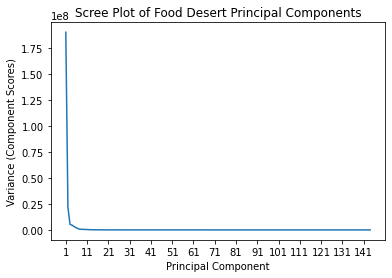

In [28]:
total_variance = np.sum(np.square(s2))/len(fd_features)
y = (s2**2/np.sum(s2**2))* total_variance
x = np.arange(1, 145)
plt.plot(x, y)
plt.xticks((np.arange(1, 150, 10)))
plt.title("Scree Plot of Food Desert Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance (Component Scores)")

Text(0, 0.5, 'Sum of within cluster variance')

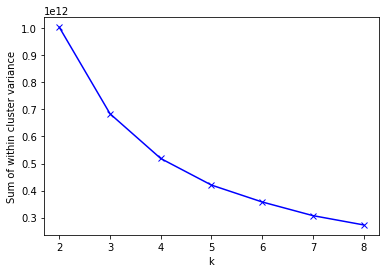

In [29]:
squarederror = []
for k in np.arange(2, 9):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(fdpca_2d)
    squarederror.append(kmeans.inertia_)
plt.plot(np.arange(2, 9), squarederror, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of within cluster variance')

Text(0.5, 1.0, '9245 Food Deserts Clustered')

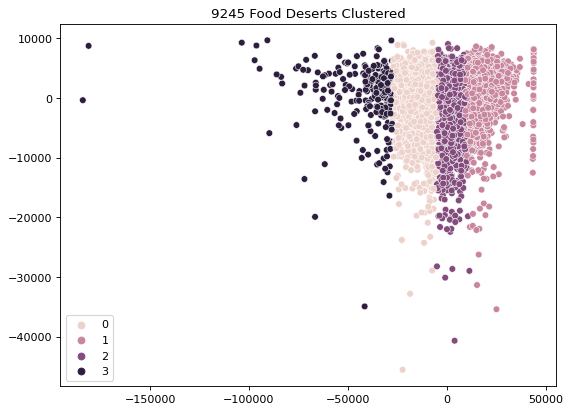

In [30]:
fdkmeans = KMeans(n_clusters=4)
fdkmeans.fit(fdpca_2d)
fdclusters = fdkmeans.predict(fdpca_2d)
fdx = []
fdy = []
for i in fdpca_2d:
  fdx.append(i[0])
  fdy.append(i[1])
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x=fdx, y=fdy, hue=fdclusters)
plt.title('9245 Food Deserts Clustered')

In [40]:
fooddeserts[fooddeserts['County'] == 'Alameda']

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
3574,6001401700,California,Alameda,1,2667,1033,0,107,0.040120,1,...,119,889,908,271,9,38,552,683,180,116
3575,6001401800,California,Alameda,1,1703,637,0,1,0.000587,1,...,116,301,993,53,7,11,338,329,221,143
3576,6001402200,California,Alameda,1,2385,849,0,15,0.006289,1,...,208,553,896,283,2,15,636,720,221,149
3766,6001435104,California,Alameda,1,5216,1923,0,10,0.001917,1,...,288,1410,1035,1116,128,27,1500,1872,255,320
3791,6001437200,California,Alameda,1,6755,2327,0,179,0.026499,1,...,1039,2255,848,2110,169,126,1247,1833,160,320
3809,6001440301,California,Alameda,1,7312,2106,0,67,0.009163,1,...,696,2221,446,2672,95,38,1840,2522,137,203


In [41]:
fooddeserts['x'] = fdx
fooddeserts['y'] = fdy
fooddeserts['cluster'] = fdclusters
fdmeans = fooddeserts.groupby('cluster').mean()
fdmeans

<ipython-input-41-b3d3de116cf4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fooddeserts['x'] = fdx
<ipython-input-41-b3d3de116cf4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fooddeserts['y'] = fdy
<ipython-input-41-b3d3de116cf4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

,CensusTract,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,...,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,x,y
cluster,,,,,,,,,,,,,,,,,,,,,
0,2.908162e+10,0.836060,4506.333697,1718.797892,0.004362,153.736096,0.033538,1.0,1.0,0.855325,...,631.667394,127.883679,13.513631,53.306798,427.625227,711.557615,124.297346,261.921483,-11809.553707,-215.259193
1,2.847774e+10,0.926782,3699.209056,1289.084297,0.032274,238.982659,0.065933,1.0,1.0,0.949422,...,1409.186416,55.382948,3.921484,130.924855,434.107900,919.115607,212.680154,434.757707,16780.249660,883.531835
2,2.838507e+10,0.825287,4361.281788,1630.255019,0.003824,155.757170,0.034052,1.0,1.0,0.849187,...,845.579828,72.151291,7.583413,85.950048,465.605641,932.120220,144.381931,347.384321,1847.057577,-317.336721
3,2.792977e+10,0.974359,4668.683761,1616.982906,0.072650,617.807692,0.121925,1.0,1.0,0.974359,...,508.393162,322.367521,9.380342,29.337607,401.948718,631.098291,105.401709,137.303419,-43058.995503,366.251246


In [42]:
fdmeans[['lawhite1share', 'lawhite10share', 'lablack1share', 'lablack10share']]

,lawhite1share,lawhite10share,lablack1share,lablack10share
cluster,,,,
0,0.439671,0.066788,0.070900,0.003534
1,0.243561,0.016433,0.242452,0.008609
2,0.405193,0.065226,0.107239,0.008378
3,0.378290,0.010712,0.052327,0.000187


In [43]:
# Normalize data into standard units
standard_scaler = MinMaxScaler()
fd_scaled = pd.DataFrame(
      standard_scaler.fit_transform(fd_features),
      columns=fd_features.columns)
fd_scaled

,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1.0,0.126225,0.171875,0.0,0.003057,0.012452,0.0,0.0,1.0,1.0,...,0.080681,0.168205,0.032848,0.003158,0.000859,0.001221,0.014561,0.006355,0.076879,0.102927
1,0.0,0.144995,0.188947,0.0,0.002802,0.009940,0.0,0.0,0.0,1.0,...,0.110489,0.103893,0.136676,0.000486,0.000000,0.001554,0.008039,0.002529,0.112450,0.123702
2,1.0,0.145214,0.171586,0.0,0.001189,0.004210,0.0,0.0,1.0,1.0,...,0.068355,0.095386,0.139772,0.000729,0.000000,0.003330,0.017898,0.005966,0.089501,0.146837
3,1.0,0.209704,0.312645,0.0,0.000340,0.000834,0.0,0.0,1.0,0.0,...,0.233079,0.326244,0.004229,0.008744,0.000286,0.002886,0.023510,0.003696,0.036718,0.067517
4,1.0,0.460623,0.626447,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,...,0.421784,0.563663,0.127841,0.027447,0.002292,0.008214,0.125588,0.085214,0.140562,0.289424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9240,1.0,0.134144,0.114873,0.0,0.042710,0.163737,0.0,0.0,1.0,0.0,...,0.000672,0.175270,0.017594,0.017488,0.002865,0.002331,0.046261,0.022503,0.003442,0.001889
9241,1.0,0.214079,0.310909,0.0,0.000934,0.002245,0.0,0.0,1.0,1.0,...,0.153294,0.308652,0.009817,0.010687,0.001432,0.003330,0.062035,0.043320,0.095238,0.167611
9242,1.0,0.191591,0.296586,0.0,0.015878,0.042645,0.0,0.0,1.0,1.0,...,0.118333,0.261788,0.009665,0.008744,0.000286,0.009990,0.075686,0.048833,0.194492,0.227573
9243,1.0,0.252144,0.367911,0.0,0.005604,0.011440,0.0,0.0,1.0,0.0,...,0.218512,0.396107,0.000680,0.004858,0.002005,0.005106,0.029273,0.013100,0.021801,0.062795


In [44]:
# This is the size of our encoded representations
encoding_dim = 2  # Reduce 144 dimensions to 2 for clustering visualization

# This is our input image
inputs = keras.Input(shape=(144,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(inputs)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(144, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(inputs, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(inputs, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [45]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(fd_scaled, fd_scaled,
                epochs=50,
                batch_size=256,
                shuffle=True)

Epoch 1/50
37/37 [==============================] - 1s 4ms/step - loss: 0.6829
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.6393
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.5368
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.4115
Epoch 5/50
37/37 [==============================] - 0s 3ms/step - loss: 0.3263
Epoch 6/50
37/37 [==============================] - 0s 3ms/step - loss: 0.2825
Epoch 7/50
37/37 [==============================] - 0s 3ms/step - loss: 0.2608
Epoch 8/50
37/37 [==============================] - 0s 4ms/step - loss: 0.2490
Epoch 9/50
37/37 [==============================] - 0s 3ms/step - loss: 0.2418
Epoch 10/50
37/37 [==============================] - 0s 4ms/step - loss: 0.2369
Epoch 11/50
37/37 [==============================] - 0s 4ms/step - loss: 0.2334
Epoch 12/50
37/37 [==============================] - 0s 4ms/step - loss: 0.2306
Epoch 13/50
37/37 [==============================

In [46]:
# Encode the dataset using autoencoder
encoded = encoder.predict(fd_scaled)
encoded

289/289 [==============================] - 0s 1ms/step


array([[6.800732  , 5.1953    ],
       [0.55647194, 6.808281  ],
       [7.3539023 , 5.0853176 ],
       ...,
       [7.748908  , 6.322261  ],
       [6.1930614 , 5.410346  ],
       [1.0693294 , 4.8386927 ]], dtype=float32)

Text(0, 0.5, 'Sum of within cluster variance')

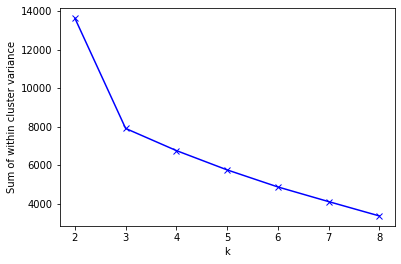

In [47]:
squarederror = []
for k in np.arange(2, 9):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(encoded)
    squarederror.append(kmeans.inertia_)
plt.plot(np.arange(2, 9), squarederror, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of within cluster variance')
# Set k=3 because we see elbow bend at 3 drastically here.

Text(0.5, 1.0, '9245 Food Deserts Clustered')

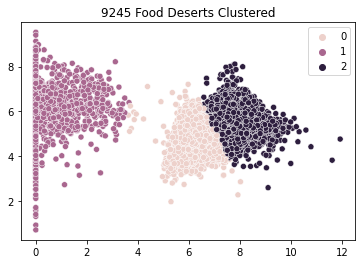

In [48]:
autokmeans = KMeans(n_clusters=3)
autokmeans.fit(encoded)
autoclusters = autokmeans.predict(encoded)
ax = []
ay = []
for i in encoded:
  ax.append(i[0])
  ay.append(i[1])
# figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x=ax, y=ay, hue=autoclusters)
plt.title('9245 Food Deserts Clustered')

In [52]:
fd_autoencoder = fooddeserts
fd_autoencoder['x'] = ax
fd_autoencoder['y'] = ay
fd_autoencoder['cluster'] = autoclusters
fd_automeans = fd_autoencoder.groupby('cluster').mean()
fd_automeans

<ipython-input-52-41c43314027d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fd_autoencoder['x'] = ax
<ipython-input-52-41c43314027d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fd_autoencoder['y'] = ay
<ipython-input-52-41c43314027d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

,CensusTract,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,...,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,x,y
cluster,,,,,,,,,,,,,,,,,,,,,
0,2.814694e+10,0.998383,3971.479784,1426.625606,0.024259,218.197574,0.056107,1.0,1.0,0.998383,...,595.578976,103.101348,10.980323,55.797305,484.367385,922.025606,91.506739,256.148518,6.266108,4.763022
1,2.870393e+10,0.008915,3485.850669,1323.355869,0.003715,118.546805,0.028524,1.0,1.0,0.157504,...,376.210996,18.713967,5.291233,302.406389,192.968053,329.636701,83.699108,227.303120,0.688744,6.333238
2,2.897144e+10,1.000000,4772.120315,1797.539986,0.004058,178.141323,0.036667,1.0,1.0,1.000000,...,1337.808546,104.178324,7.491525,40.792552,492.484364,966.541179,229.189544,442.212222,7.826071,5.454495


In [53]:
fd_automeans[['lawhite1share', 'lawhite10share', 'lablack1share', 'lablack10share']]

,lawhite1share,lawhite10share,lablack1share,lablack10share
cluster,,,,
0,0.333986,0.000934,0.080349,0.000110
1,0.715910,0.363371,0.097312,0.046196
2,0.309456,0.000167,0.174321,0.000025
